# Constructing a mapping

A mapping is written by an EO expert and contains rules that map semantic concepts formalized in an ontology to data values stored in an EO data cube. As such, the mapping forms the connection between the semantic domain and the image domain. 

This notebook describes the data structures to represent a mapping in semantique, and shows how an EO expert can construct a mapping from scratch.

## Content

- [Structure](#Structure)
- [The Semantique configuration](#The-Semantique-configuration)

## Prepare

Import packages:

In [1]:
import semantique as sq

In [2]:
import geopandas as gpd
import json

## Structure

The rules in the mapping should support computational inference on the pixel level. That is, for each spatio-temporal location contained in the EO data cube, they should be able to quantify a relation to the semantic concept. Such a relation may be binary, stating if the concept was observed at the location or not. However, relations may also be numeric (e.g. a probability that the concept was observed) or ordinal (e.g. "likely" or "very likely" that the concept was observed). It is important to emphasize here that there is no limitation to formulate rules as a function of only the data values of the pixel to which they are applied. In order to quantify the relations more accurately, the EO expert may exploit all the values in the EO data cube. For example, they may analyze spatial or temporal patterns around the location of the pixel.

How the rules are formulated in practice depends largely on the approach that the EO expert decides to take. This can be entirely knowledge-driven, but also hybrid approaches combining knowledge-driven and data-driven components are possible. For example, a rule may interpret the prediction of a machine learning classifier. Approaches can also differ in how they encode the formulated rules. We refer to all these different approaches as different *configurations* of a mapping. 

The structure of semantique is flexible and does not put any limitations on what the configuration of a mapping should be. Instead, it allows expert users to create their own class that implements their specific mapping configuration. Such a class should always inherit from the abstract base class [Mapping](https://zgis.github.io/semantique/semantique.mapping.Mapping.html) that semantique contains. Such a base class can be seen as a blueprint for any object that represents a mapping.

In [3]:
base = sq.mapping.Mapping()

The mapping base class inherits from the Python dictionary class, meaning that every mapping configuration should have the structure of a Python dictionary. In this dictionary, the names of semantic concepts are the keys and the rules that map them to data in an EO data cube are the values. The dictionary may have a nested structure formalizing a categorization of semantic concepts, e.g. the rules of the semantic concept water can be indexed by the key pair ("entity", "water") instead of only "water". The depth of this index depends on the structure of the ontology to which the mapping refers.

In [4]:
isinstance(base, dict)

True

The mapping base class requires each mapping configuration to have a [translate()](https://zgis.github.io/semantique/semantique.mapping.Mapping.translate.html) method that implements the translator of the mapping, with fixed input and output types. The translator is an interface that exposes the rules in the mapping to the other components of the querying framework. Given a textual reference to a semantic concept, it is able to apply the corresponding rules to the data values in the EO data cube, and return for each pixel the quantified relation with the semantic concept. The exact implementation of the translator depends on the configuration of the mapping, but the inputs it accepts and the output it returns does not. Hence, the translator serves as a standardized API that allows other components of the framework to evaluate the rules in the mapping independent from its configuration.

In [5]:
hasattr(base, "translate")

True

It is important to note here that when evaluating a query recipe the query processor does not care at all what the configuration of the mapping is and how it translates semantic concept references. It only interacts with the translator function, and thus only cares about what input the translator function accepts, and in what format it returns the translated concepts.

## The Semantique configuration

Semantique formalizes its own native mapping configuration through the [Semantique](https://zgis.github.io/semantique/semantique.mapping.Semantique.html) sub-class. It implements a knowledge-driven approach in which the EO expert formulates rules that quantify binary relations between properties of semantic concepts and data values, rather than directly from semantic concepts to data values. For example, a entity *lake* may be defined by its *color* (a blueish, water-like color) in combination with its *texture* (it has an approximately flat surface). These property relations are then combined with a logical “and” operator to quantify the relation for the semantic concept as a whole, meaning that the concept is only observed if all its properties are observed.

To formulate the rules for each property, the EO expert can use the same building blocks as made available for [writing query recipes](recipes.ipynb), and combine them into processing chains. However, where in a query recipe such a processing chain usually start with a [reference to a semantic concept](references.ipynb#Referencing-semantic-concepts), in the mapping they will usually start with a [reference to a data layer](references.ipynb#Referencing-data-layers) in the EO data cube. Such a reference can then be directly followed by an [evaluate verb](verbs#Evaluate) that evaluates a condition on the data values of one or more layers. More complex rules can be formulated by utilizing more verbs, and nesting multiple processing chains into each other.

Below we will show some examples on how you can construct rules with the Semantique mapping configuration. They are heavily simplified and don't always make sense, but are meant mainly to get an idea of how the mapping construction works. First, we need to create an instance of the Semantique class, which inherits from the abstract base class Mapping. We can create an instance of it by providing a dictionary with rules that was shared with us. However, when creating a mapping from scratch, we start with an empty mapping, and iteratively fill it with rules afterwards.

In [6]:
mapping = sq.mapping.Semantique()

In [7]:
isinstance(mapping, sq.mapping.Mapping)

True

In our example, we will focus solely on defining entities, and use a one-layer categorization. That is, our only category is *entity*. The first step is to add this category as a key to the mapping. Its value can still be an empty dictionary. We will add the concept definitions afterwards.

In [8]:
mapping["entity"] = {}

Now, we need to construct rules that define a binary relationship between the distinct properties of an entity and the data values in the EO data cube. That is, the rules should define for each pixel in our data if it meets a specific property ("true"), or not ("false"). As said, we can do this by applying the same building blocks as we did for constructing our query recipe, but now starting with a reference to a data layer in the EO data cube. For example: we utilize the ("appearance", "colortype") data layer in the EO data cube to define if a pixel has a water-like color. This is a layer of semantically enriched data and contains categorical values. The categories with indices 21, 22, 23 and 24 correspond to color combinations that *appear* to be water. Hence, we state that a pixel meets the color property of a lake when its value in the ("appearance", "colortype") corresponds with one of the above mentioned indices. Furthermore, we state that a pixel meets the texture property of a lake when its value in the ("topography", "slope") layer equals 0.

In [9]:
mapping["entity"]["lake"] = {
    "color": sq.appearance("colortype").evaluate("in", [21, 22, 23, 24]),
    "texture": sq.topography("slope").evaluate("equal", 0)
}

The way that semantique parses the layout of the EO data cube, you can also access labels and/or descriptions of category indices in an auto-complete friendly way.

In [10]:
with open("files/layout.json", "r") as file:
    dc = sq.datacube.GeotiffArchive(json.load(file), src = "files/layers.zip")
    
layout = dc.layout

In [11]:
descriptions = layout["appearance"]["colortype"]["descriptions"]

In [12]:
indices = [
    descriptions["Deep water or shadow"],
    descriptions["Shallow water or shadow"],
    descriptions["Turbid water or shadow"],
    descriptions["Salty Shallow Water"]
]

In [13]:
mapping["entity"]["lake"] = {
    "color": sq.appearance("colortype").evaluate("in", indices),
    "texture": sq.topography("slope").evaluate("equal", 0)
}

Now we define a second entity *river*, which we say has the same color property of a lake, but instead has a non-zero slope.

In [14]:
mapping["entity"]["river"] = {
    "color": sq.appearance("colortype").evaluate("in", [21, 22, 23, 24]),
    "texture": sq.topography("slope").evaluate("not_equal", 0) 
}

As you see, there is a relation between the entities *lake* and *river*. They share a property. However, we defined the same property twice. This is not needed, since you can always refer to other entities in the mapping, as well as to properties of these entities. In this way, you can intuitively model relations between different semantic concepts. Hence, the same *river* definition can also be structured as follows:

In [15]:
mapping["entity"]["river"] = {
    "color": sq.entity("lake", property = "color"),
    "texture": sq.entity("lake", property = "texture").evaluate("not")
}

Or, to take it a step further, as below. Basically we are saying here that a *lake* has the color of *water* and the texture of a *plain* (again, we oversimplify here!).

In [16]:
mapping["entity"]["water"] = {
    "color": sq.appearance("colortype").evaluate("in", [21, 22, 23, 24]),
}

mapping["entity"]["vegetation"] = {
    "color": sq.appearance("colortype").evaluate("in", [1, 2, 3, 4, 5, 6]),
}

mapping["entity"]["plain"] = {
    "color": sq.entity("vegetation", property = "color"),
    "texture": sq.topography("slope").evaluate("equal", 0) 
}

mapping["entity"]["lake"] = {
    "color": sq.entity("water", property = "color"),
    "texture": sq.entity("plain", property = "texture")
}

mapping["entity"]["river"] = {
    "color": sq.entity("water", property = "color"),
    "texture": sq.entity("plain", property = "texture").evaluate("not")
}

We can also model relationships in a way where some entity is the union of other entities.

In [17]:
mapping["entity"]["natural_area"] = {
    "members": sq.collection(sq.entity("water"), sq.entity("vegetation")).merge("or")
}

It is also possible to include temporal information. For example, we only consider an observation to be part of a lake when over time more than 80% of the observations at that location are identified as water, excluding those observations that are identified as a cloud.

In [18]:
mapping["entity"]["lake"] = {
    "color": sq.entity("water", property = "color"),
    "texture": sq.entity("plain", property = "texture"),
    "continuity": sq.entity("water", property = "color").\
        filter(sq.entity("cloud").evaluate("not")).\
        reduce("percentage", "time").\
        evaluate("greater", 80)
}

Besides referencing data layers or other entities, a ruleset may also start with a [self reference](references.ipynb#Referencing-the-active-evaluation-object). This means that when translating the semantic concept within a query recipe, the rules are applied to the array that at that moment is the active evaluation object of the query processor. This may sound slighlty overwhelming, but basically it allows for example to model custom seasons as being temporal entities, and use them as a temporal filter in a query recipe.

In [19]:
mapping["entity"]["harvest_season"] = {
    "timespan": sq.self().extract("time", "month").evaluate("in", [8, 9, 10])
}

recipe = sq.QueryRecipe()
recipe["vegetation_during_harvest"] = sq.entity("vegetation").filter(sq.entity("harvest_season"))

The flexible structure with the building blocks of semantique make many more structures possible. Now you have an idea of how to construct a mapping from scratch using the built-in Semantique configuration, we move on and construct a complete mapping in one go. However, we use simpler rules as above, since our demo EO data cube only contains a very limited set of resources.

In [20]:
mapping = sq.mapping.Semantique()
mapping["entity"] = {}

mapping["entity"]["water"] = {"color": sq.appearance("colortype").evaluate("in", [21, 22, 23, 24])}
mapping["entity"]["vegetation"] = {"color": sq.appearance("colortype").evaluate("in", [1, 2, 3, 4, 5, 6])}
mapping["entity"]["builtup"] = {"color": sq.appearance("colortype").evaluate("in", [13, 14, 15, 16, 17])}
mapping["entity"]["cloud"] = {"color": sq.atmosphere("colortype").evaluate("equal", 25)}
mapping["entity"]["snow"] = {"color": sq.appearance("colortype").evaluate("in", [29, 30])}

Our constructed mapping looks like [this](https://github.com/ZGIS/semantique/blob/main/demo/files/mapping.json). We can easily export and share this mapping as a JSON file.

In [21]:
with open("files/mapping.json", "w") as file:
    json.dump(mapping, file, indent = 2)

That also means that as non-EO-expert you don't have to worry about constructing your own mapping from scratch. You can simply load a shared mapping and use it to initialize a Semantique mapping instance.

In [22]:
with open("files/mapping.json", "r") as file:
    rules = json.load(file)

mapping = sq.mapping.Semantique(rules)

As mentioned, internally the query processor will only interact with the translator function of the provided mapping instance. To show how this works, we do need to provide a spatio-temporal extent inside which the concept needs to be translated and a EO data cube instance from which the translator can retrieve the referenced data layers. Also here, the translator only interacts with the retriever function of the EO data cube instance, and hence does not care what the configuration of the cube is.

In [23]:
from semantique.processor.utils import parse_extent

In [24]:
space = sq.SpatialExtent(gpd.read_file("files/footprint.geojson"))
time = sq.TemporalExtent("2019-01-01", "2020-12-31")

extent = parse_extent(space, time, spatial_resolution = [-10, 10], crs = 3035)

In [25]:
with open("files/layout.json", "r") as file:
    dc = sq.datacube.GeotiffArchive(json.load(file), src = "files/layers.zip")

In [26]:
water = mapping.translate("entity", "water", extent = extent, datacube = dc)

In [27]:
water

<xarray.DataArray 'water' (time: 3, y: 563, x: 576)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * x              (x) float64 4.53e+06 4.53e+06 ... 4.536e+06 4.536e+06
  * y              (y) float64 2.697e+06 2.697e+06 ... 2.691e+06 2.691e+06
    spatial_ref    int64 0
  * time           (time) datetime64[ns] 2019-12-15T10:17:33.408715 ... 2020-...
    temporal_ref   int64 0
    spatial_feats  (y, x) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     1.7976931348623157e+308
    value_type:     binary

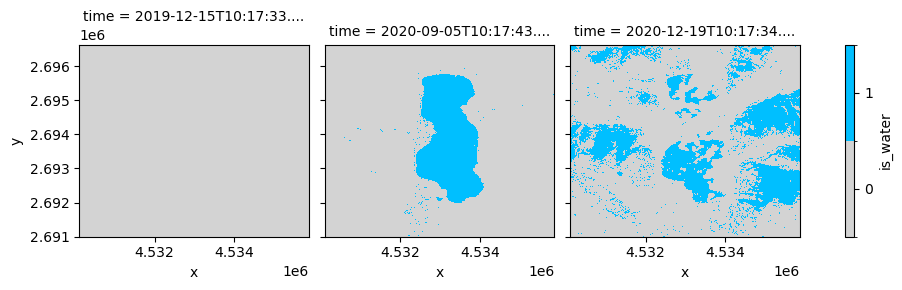

In [28]:
levels = [-0.5, 0.5, 1.5]
legend = {"ticks": [0, 1], "label": "is_water"}
colors = ["lightgrey", "deepskyblue"]
water.plot(x = "x", y = "y", col = "time", colors = colors, levels = levels, cbar_kwargs = legend)